In [121]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from collections import Counter
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

- `InvoiceNo`: This is an object data type column that contains the invoice number for each transaction. Each invoice number can represent multiple items purchased in a single transaction.
- `StockCode`: An object data type column representing the product code for each item.
- `Description`: This column, also an object data type, contains descriptions of the products. It has some missing values, with 540,455 non-null entries out of 541,909.
- `Quantity`: This is an integer column indicating the quantity of products purchased in each transaction.
- `InvoiceDate`: A datetime column that records the date and time of each transaction.
- `UnitPrice`: A float column representing the unit price of each product.
- `CustomerID`: A float column that contains the customer ID for each transaction. This column has a significant number of missing values, with only 406,829 non-null entries out of 541,909.
- `Country`: An object column recording the country where each transaction took place.

In [2]:
df = pd.read_csv('/Users/adamrivardwalter/Data for Processing/Preprocessing/Classification/Customer Segmentation/data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


### Data Cleaning

In [5]:
missing_data = df.isnull().sum()
print(missing_data)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [6]:
missing_percent = missing_data[missing_data > 0] / df.shape[0] * 100
print(missing_percent)

Description     0.268311
CustomerID     24.926694
dtype: float64


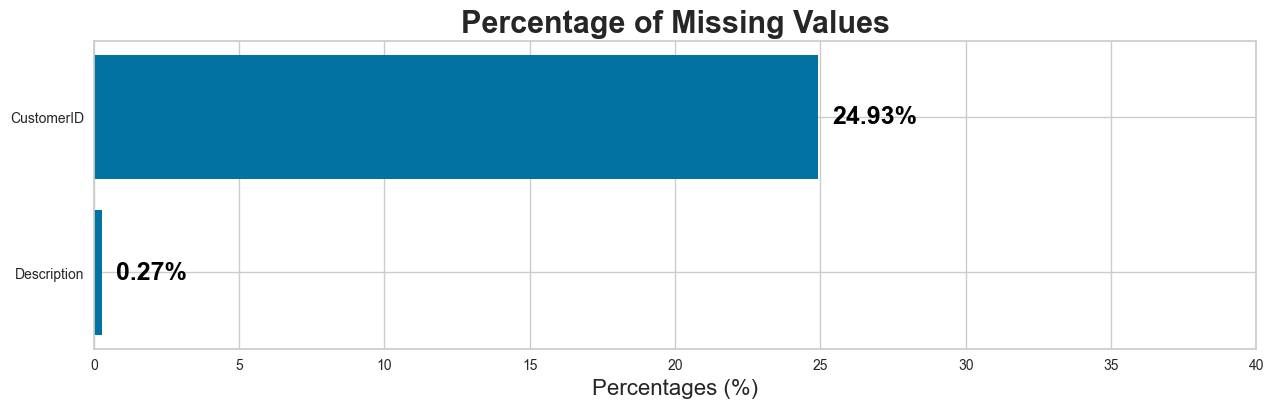

In [7]:
# Plot the bar chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percent.index, missing_percent)

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percent, missing_percent.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [8]:
# Remove rows with missing values in 'CustomerID' and 'Description' columns
df = df.dropna(subset=['CustomerID', 'Description'])

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### Handling Duplicates

In [10]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [11]:
df.shape[0]

401604

#### Cancelled Transactions

Some of the entries in `InvoiceNo` start with a 'C' to indicate that the order was cancelled. We need to create a new column called 'Transaction_Status' and fill in the values where the `InvoiceNo` was cancelled if the invoice starts with a 'C', otherwise, we need to fill in that column with 'Completed'


In [12]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

In [13]:
cancelled_orders = df[df['InvoiceNo'].str.startswith('C')]

In [14]:
# Note that cancelled values are negative
cancelled_orders.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,8872.0,-30.774910,1172.249902,-80995.00,-6.00,-2.00,-1.00,-1.0
UnitPrice,8872.0,18.899512,445.190864,0.01,1.45,2.95,4.95,38970.0
CustomerID,8872.0,14990.152953,1708.230387,12346.00,13505.00,14868.00,16393.00,18282.0


In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


In [16]:
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,Cancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,Cancelled
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,Cancelled
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled


In [17]:
cancelled_percent = cancelled_orders.shape[0] / df.shape[0] * 100
print(f"The cancelled orders in our dataset is: {cancelled_percent:.2f}%")

The cancelled orders in our dataset is: 2.21%


#### StockCode Anomalies

In [18]:
n_unique_stock_codes = df['StockCode'].nunique()
print(f"The number of unique stock codes in the dataset is {n_unique_stock_codes}")

The number of unique stock codes in the dataset is 3684


### Exploritory Data Analysis

In [19]:
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

In [20]:
top_10_stock_codes

StockCode
85123A    0.514188
22423     0.471609
85099B    0.413093
47566     0.350843
84879     0.349847
20725     0.335156
22720     0.304778
POST      0.297806
22197     0.276392
23203     0.275894
Name: proportion, dtype: float64

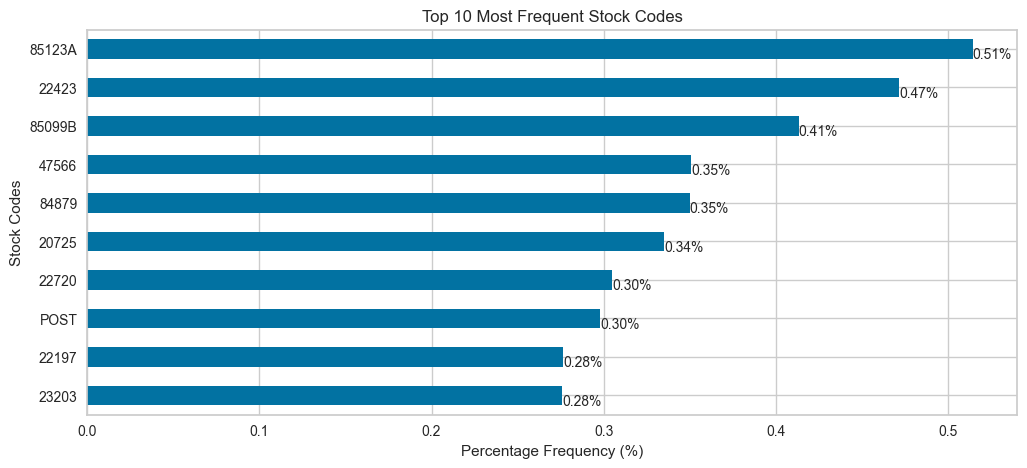

In [21]:
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [22]:
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes) \
    .apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

In [23]:
print("Value counts of numeric character frequencies in unique stock codes:")
print('--------------------------------------------------------------------')
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
--------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [24]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print('----------------------')
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [25]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
print(f"The percentage of anomalous stock codes in our dataset: {percentage_anomalous:.2f}%")

The percentage of anomalous stock codes in our dataset: 0.48%


In [26]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [27]:
df.shape[0]

399689

#### Description Column

In [28]:
# Sort occurrence of each unique description
description_counts = df['Description'].value_counts()

In [29]:
top_25_descriptions = description_counts[:25]

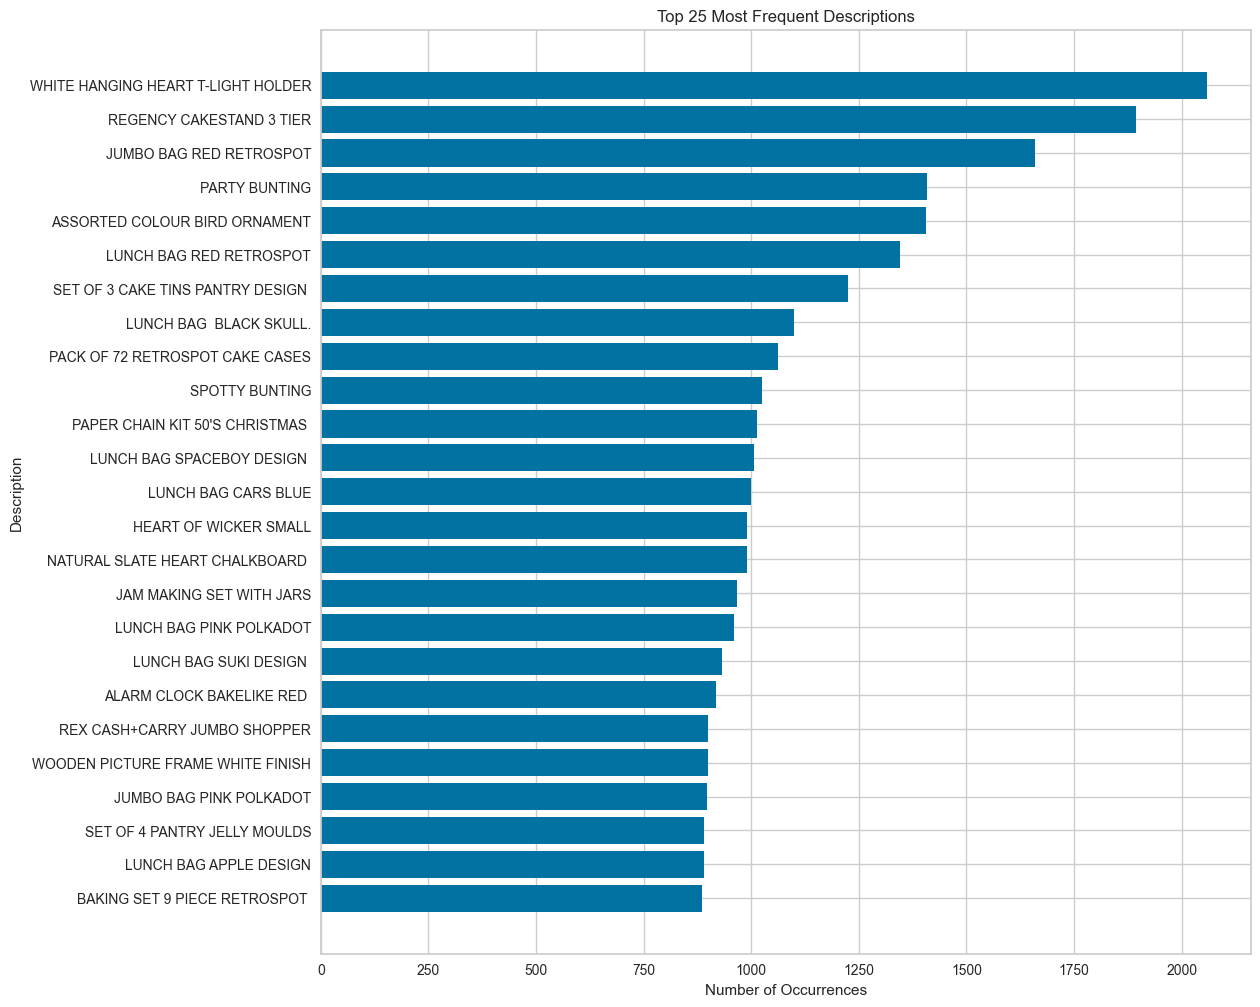

In [30]:
plt.figure(figsize=(12,12))
plt.barh(top_25_descriptions.index[::-1], top_25_descriptions.values[::-1])

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 25 Most Frequent Descriptions')

# Show the plot
plt.show()

In [31]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("------------------------------------------------------------")
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


Some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". These entries seem to be unrelated to the actual products and might represent other types of information or service details and will have to be removed to improve our accuracy for customer segmentation.

In [32]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [33]:
df.shape[0]

399606

#### Zero Unit Prices

In [34]:
df['UnitPrice'].describe().T

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [35]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [36]:
# Remove unit prices of 0.00
df = df[df['UnitPrice'] > 0]

In [37]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

### Feature Engineering

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

- **Recency (R)**: This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.
- **Frequency (F)**: This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.
- **Monetary (M)**: This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

 #### Recency (R)
- **Days Since Last Purchase**: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [38]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [39]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


#### Frequency (F)
- **Total Transactions**: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.
- **Total Products Purchased**: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

In [40]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

In [41]:
total_transactions.head()

,CustomerID,Total_Transactions
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [42]:
total_products_purchased.head()

,CustomerID,Total_Products_Purchased
0,12346.0,0
1,12347.0,2458
2,12348.0,2332
3,12349.0,630
4,12350.0,196


In [43]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

In [44]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


#### Monetary (M)

- **Total Spend**: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.
- **Average Transaction Value**: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [45]:
# Calculate the total spend by each customer
df['TotalSpent'] = df['UnitPrice'] * df['Quantity']
total_spent = df.groupby('CustomerID')['TotalSpent'].sum().reset_index()


In [46]:
total_spent.head()

,CustomerID,TotalSpent
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


In [47]:
# Calculate the average transaction by each customer
average_transaction_value = total_spent.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['TotalSpent'] / average_transaction_value['Total_Transactions']

In [48]:
average_transaction_value.head()

,CustomerID,TotalSpent,Total_Transactions,Average_Transaction_Value
0,12346.0,0.00,2,0.000000
1,12347.0,4310.00,7,615.714286
2,12348.0,1437.24,4,359.310000
3,12349.0,1457.55,1,1457.550000
4,12350.0,294.40,1,294.400000


In [49]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spent, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

In [50]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


#### Product Diversity

- **Unique Products Purchased**: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [51]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

In [52]:
unique_products_purchased.head()

,CustomerID,Unique_Products_Purchased
0,12346.0,1
1,12347.0,103
2,12348.0,21
3,12349.0,72
4,12350.0,16


In [53]:
# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

In [54]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


#### Behavioral Features

- **Average Days Between Purchases**: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.
- **Favorite Shopping Day**: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.
- **Favorite Shopping Hour**: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.


In [55]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

In [56]:
# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

In [57]:
# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

In [58]:
# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

In [59]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

In [60]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


#### Geographic Features

- **Country**: This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [61]:
df['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

In [62]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

In [63]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [64]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

#### Cancellation Insights

- **Cancellation Frequency**: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.
- **Cancellation Rate**: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

In [65]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

In [66]:
# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']

cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

In [67]:
cancellation_frequency.head()

,CustomerID,Cancellation_Frequency
0,12346.0,1
1,12352.0,1
2,12359.0,2
3,12362.0,3
4,12375.0,1


In [68]:
# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

In [69]:
# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

In [70]:
# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

In [71]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


#### Seasonality & Trends

- **Monthly_Spending_Mean**: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.
- **Monthly_Spending_Std**: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.
- **Spending_Trend**: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

In [72]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

In [73]:
# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['TotalSpent'].sum().reset_index()

In [74]:
# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['TotalSpent'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

In [75]:
# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

In [76]:
seasonal_buying_patterns.head()

,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,0.000000,0.000000
1,12347.0,615.714286,341.070789
2,12348.0,359.310000,203.875689
3,12349.0,1457.550000,0.000000
4,12350.0,294.400000,0.000000


In [77]:
# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

In [78]:
# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['TotalSpent'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'TotalSpent': 'Spending_Trend'}, inplace=True)

In [79]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

In [80]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [81]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [82]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   TotalSpent                      4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

#### Customer Dataset Description:

- `CustomerID`: Identifier uniquely assigned to each customer, used to distinguish individual customers.
- `Days_Since_Last_Purchase`: The number of days that have passed since the customer's last purchase.
- `Total_Transactions`: The total number of transactions made by the customer.
- `Total_Products_Purchased`: The total quantity of products purchased by the customer across all transactions.
- `Total_Spend`: The total amount of money the customer has spent across all transactions.
- `Average_Transaction_Value`: The average value of the customer's transactions, calculated as total spend divided by the number of transactions.
- `Unique_Products_Purchased`: The number of different products the customer has purchased.
- `Average_Days_Between_Purchases`: The average number of days between consecutive purchases made by the customer.
- `Day_Of_Week`: The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday).
- `Hour`: The hour of the day when the customer prefers to shop, represented in a 24-hour format.
- `Is_UK`: A binary variable indicating whether the customer is based in the UK (1) or not (0).
- `Cancellation_Frequency`:	The total number of transactions that the customer has cancelled.
- `Cancellation_Rate`: The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions.
- `Monthly_Spending_Mean`: The average monthly spending of the customer.
- `Monthly_Spending_Std`: The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern.
- `Spending_Trend`:	A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend.

### Outlier Detection and Treatment

Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the `Isolation Forest` algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [83]:
# Initializing the IsolationForest model
model = IsolationForest(contamination=0.05, random_state=42)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

In [84]:
# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

In [85]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


In [86]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

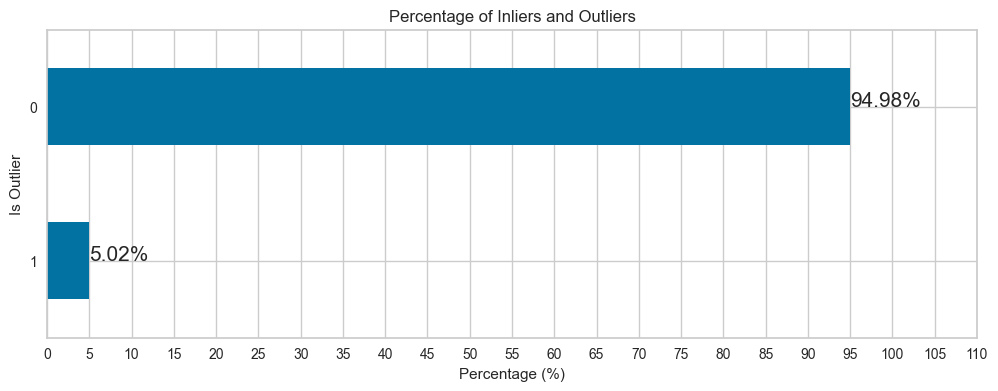

In [87]:
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [88]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

In [89]:
# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

In [90]:
# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores','Is_Outlier'])

In [91]:
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [92]:
customer_data_cleaned.shape[0]

4067

In [93]:
# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

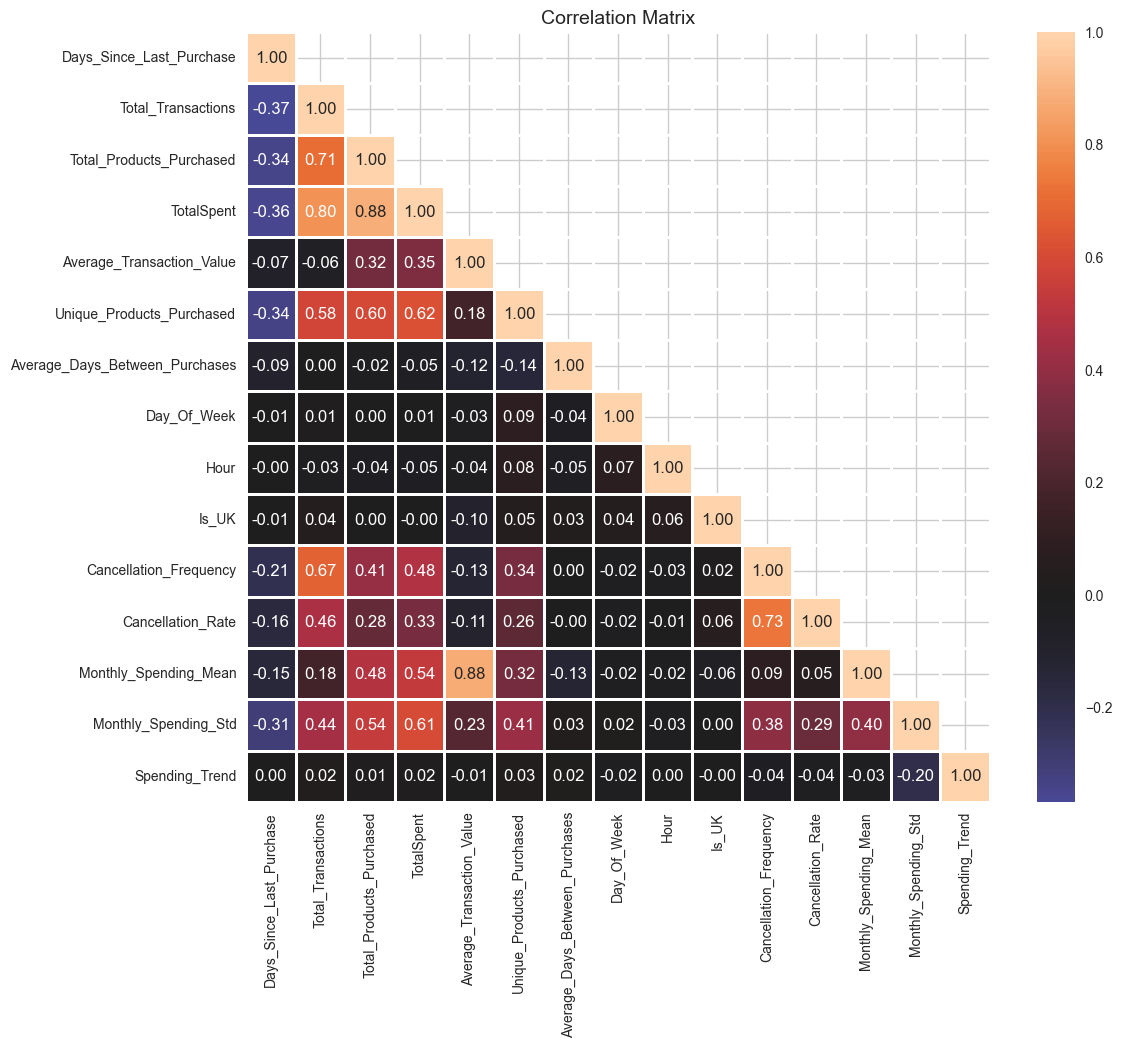

In [94]:
# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
#my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Feature Scaling

In [95]:
scaler = StandardScaler()

# List of columns that cant or shouldn't be scaled
columns_to_exlude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_include = customer_data_cleaned.columns.difference(columns_to_exlude)

# Copy of the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_include] = scaler.fit_transform(customer_data_scaled[columns_to_include])

In [96]:
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.350329,-0.470250,-0.786144,-0.829824,-1.326493,-0.889092,-0.336044,1,-1.093494,1,0.360314,0.371881,-1.346779,-0.724928,0.092604
1,12347.0,-0.901915,0.649353,2.108572,2.413080,1.564977,0.768544,-0.132491,1,0.642861,0,-0.525122,-0.422529,1.018951,1.304784,0.118692
2,12348.0,-0.166888,-0.022409,1.960185,0.251575,0.360871,-0.564066,0.762651,3,2.813304,0,-0.525122,-0.422529,0.033781,0.488336,-0.494076
3,12349.0,-0.740813,-0.694170,-0.044211,0.266857,5.518340,0.264753,-0.336044,0,-1.527582,0,-0.525122,-0.422529,4.253498,-0.724928,0.092604
4,12350.0,2.199296,-0.694170,-0.555320,-0.608314,0.056045,-0.645322,-0.336044,2,1.511038,0,-0.525122,-0.422529,-0.215620,-0.724928,0.092604


### Dimensionality Reduction

I will use Principal Component Analysis (PCA) to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components, not accurately reflecting the underlying patterns in the data.

In [97]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

In [98]:
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

Text(0.5, 1.0, 'Cumulative Variance')

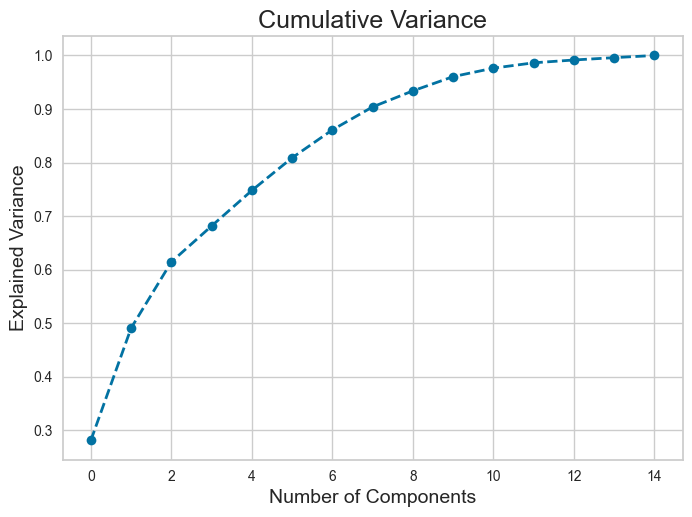

In [99]:
# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', linewidth=2)
# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance', fontsize=18)

From the graph, we can see

- The first component explains approximately 28% of the variance.

- The first two components together explain about 49% of the variance.

- The first three components explain approximately 62% of the variance, and so on.

To find the optimal number of components, we'll look for a point where adding another component doesn't significantly increase the cumulative explained variance, also knownas the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 83% of the total variance).

In [100]:
# Updated PCA with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [101]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.309199,-1.520713,-1.634860,-0.523483,-0.944116,-1.704848
12347.0,3.192271,-1.670956,1.998334,0.676769,0.430375,0.958035
12348.0,0.674337,0.513417,0.653051,0.361625,0.029832,2.598876
12349.0,1.471136,-2.916501,6.023090,-0.577609,0.273499,-1.654139
12350.0,-2.026054,-0.412933,0.492799,0.315474,-1.538141,0.374386


In [102]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

In [103]:
# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.218512,0.005272,0.053009,-0.117092,-0.375856,-0.340329
Total_Transactions,0.384107,-0.012194,-0.248869,0.123661,0.019337,-0.033099
Total_Products_Purchased,0.403259,-0.021947,0.072460,0.107493,0.087681,-0.002695
TotalSpent,0.429774,-0.022245,0.066027,0.082084,0.050336,-0.032172
Average_Transaction_Value,0.156888,-0.034979,0.600433,-0.073354,-0.019496,-0.093912
Unique_Products_Purchased,0.335427,0.040347,0.011954,0.240250,-0.093103,0.142161
Average_Days_Between_Purchases,-0.026824,-0.027969,-0.140954,-0.113066,0.764534,0.163934
Day_Of_Week,0.043312,0.994369,0.010079,-0.030633,0.038769,-0.065711
Hour,-0.013020,0.057568,-0.008346,0.277634,-0.368641,0.770971
Is_UK,0.001535,0.006770,-0.018357,0.007284,-0.001768,0.016947


### K-Means Clustering

#### Determining the Optimal Number of Clusters

To find the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

- Elbow Method

- Silhouette Method

#### Elbow Method

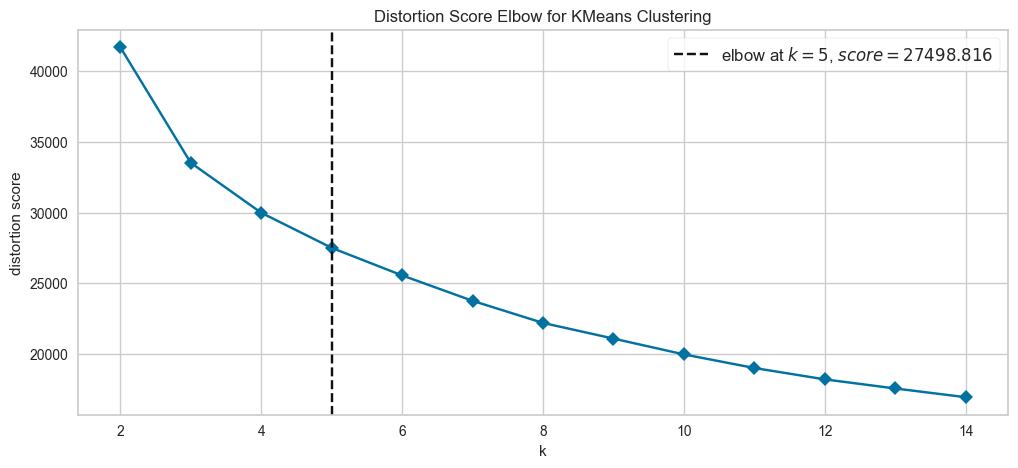

In [104]:
# Graph the clustering model with the choosen parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# KElbowVisualizer with the model and range of k values
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

#### Silhouette Method

In [105]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
   
    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

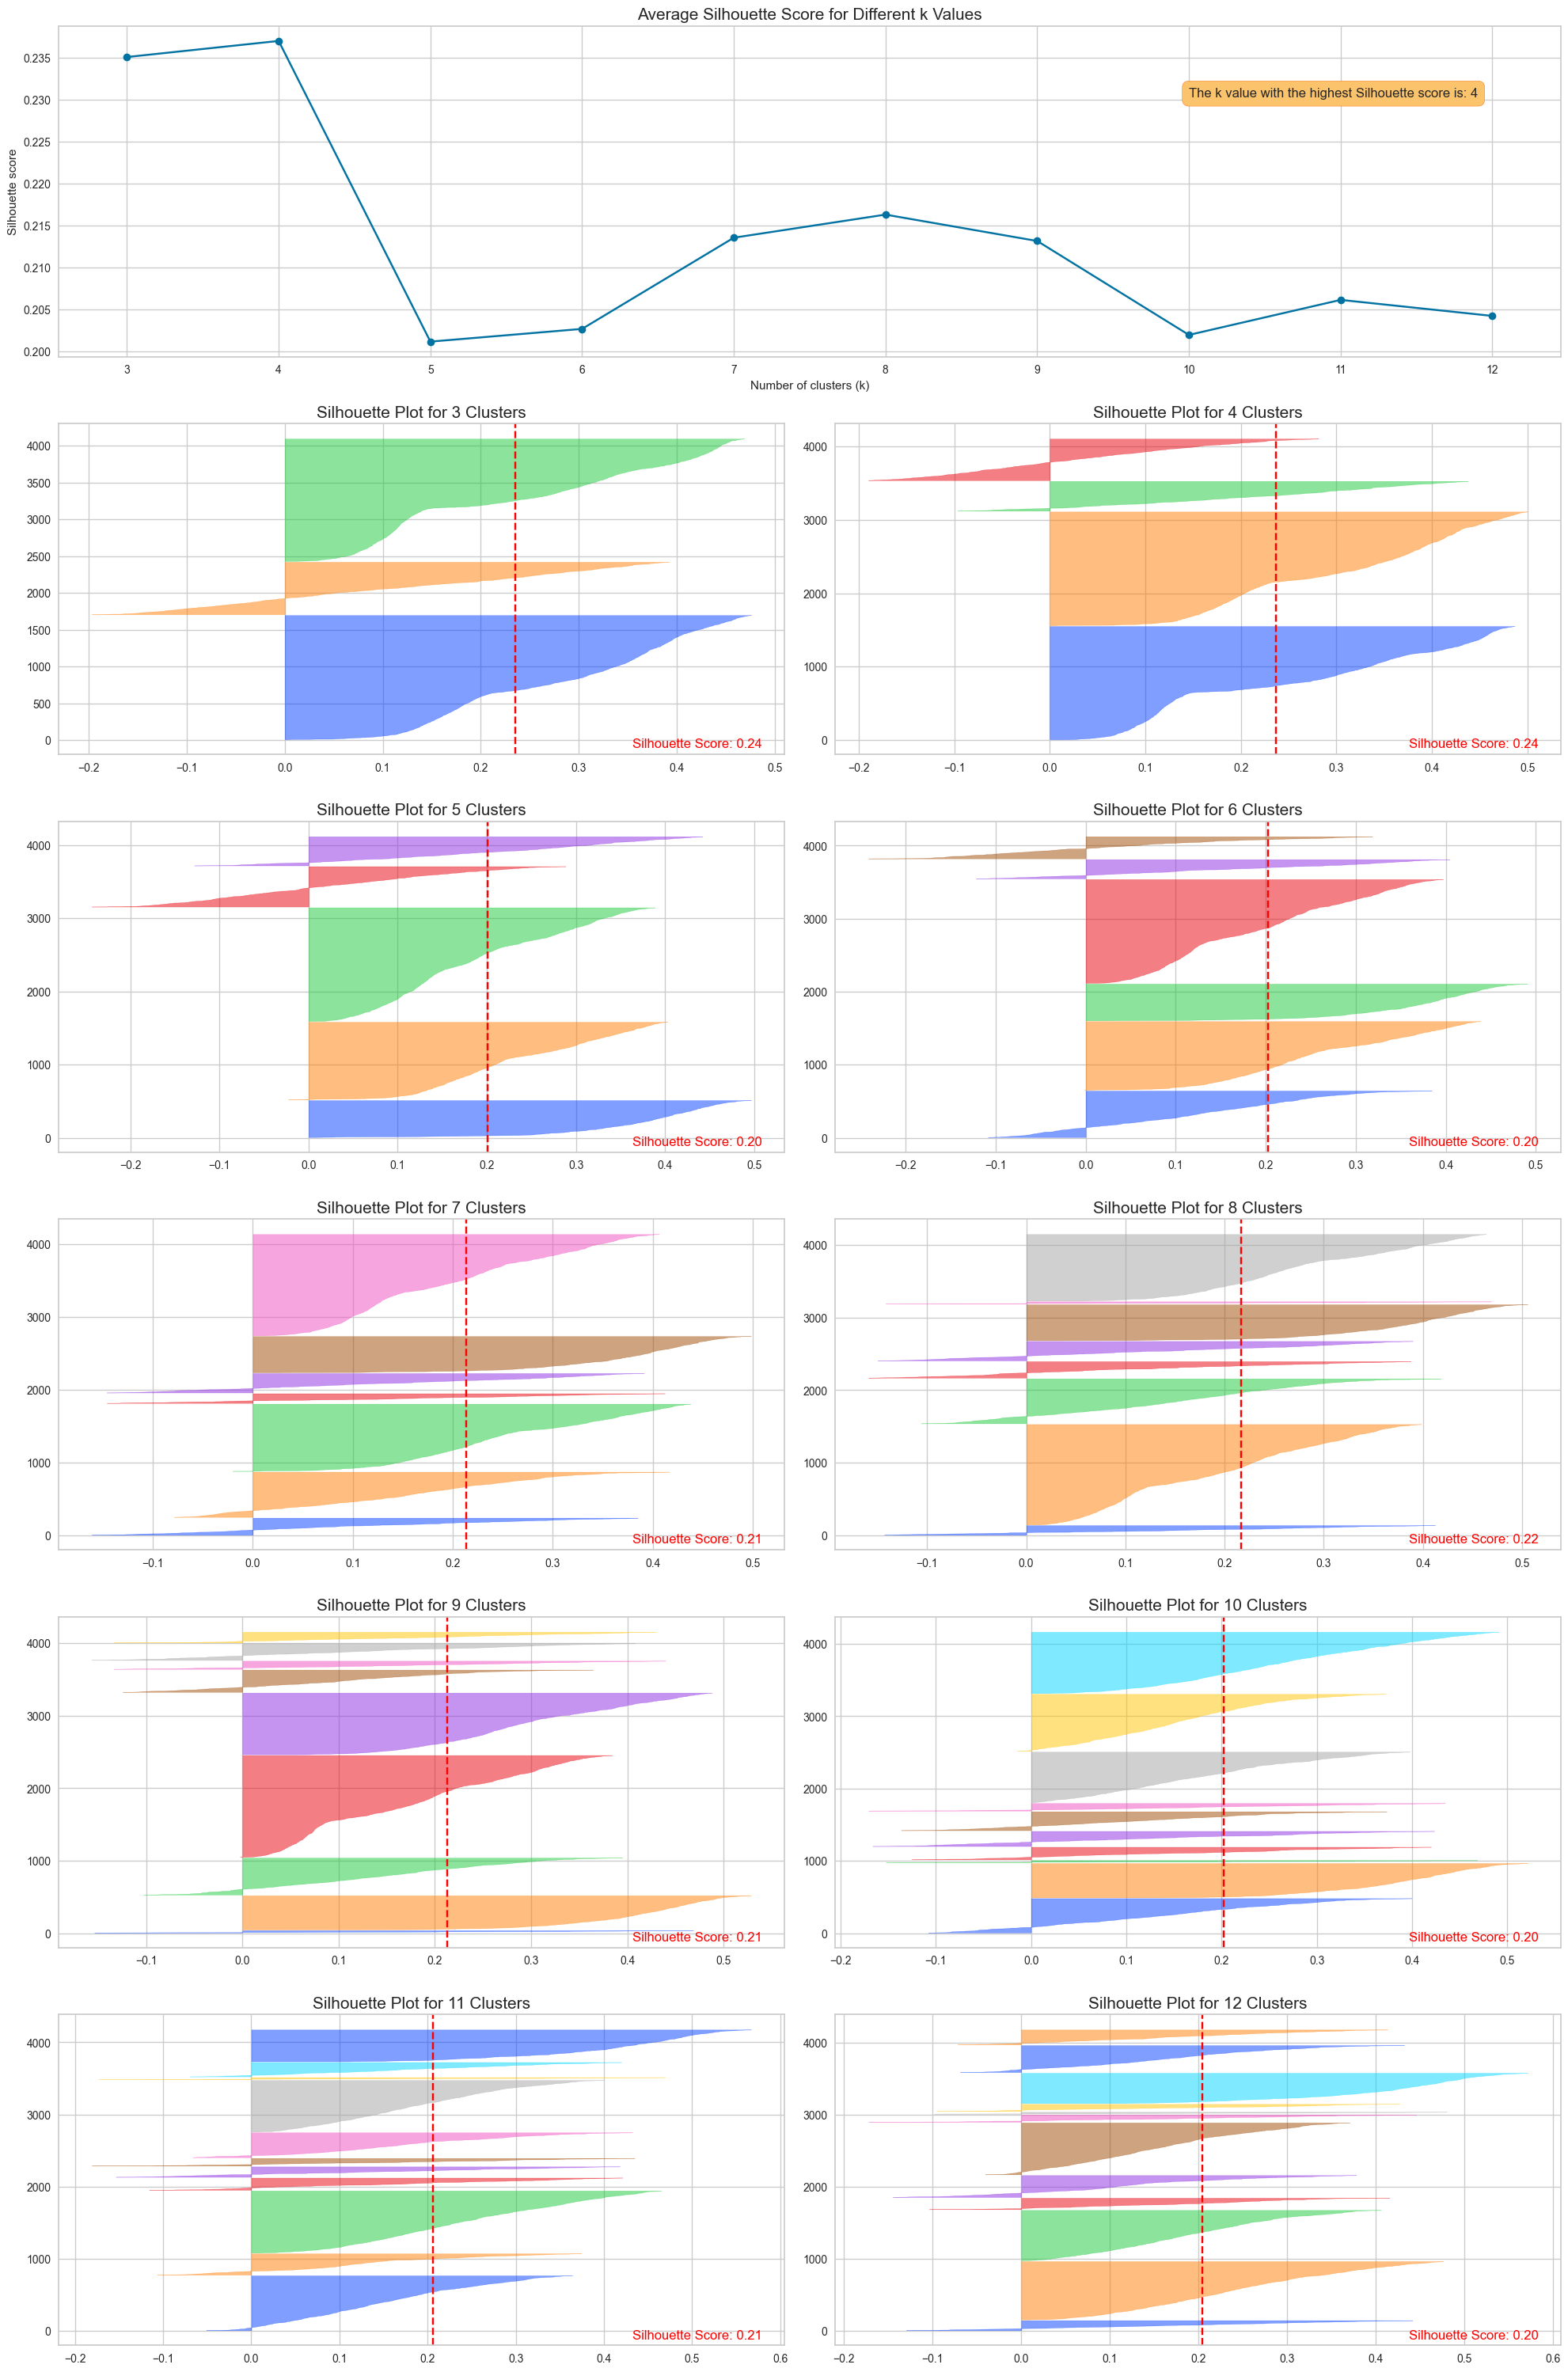

In [106]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

**Silhouette Score Width**:
The Silhouette Score Width for a single data point measures how similar that point is to its own cluster compared to other clusters. It ranges from -1 to 1:

- 1 indicates the point is well-matched to its own cluster and poorly matched to neighboring clusters.
- 0 indicates the point is on or very close to the decision boundary between two neighboring clusters.
- -1 indicates the point is assigned to the wrong cluster, as it is closer to a different cluster.

**Average Silhouette Score**:
The Average Silhouette Score is the mean of the Silhouette Scores for all data points in the dataset. It provides an overall measure of how well the clusters have been formed:

- Higher values (closer to 1) indicate better-defined clusters.
- Lower values (closer to -1) indicate poorly-defined clusters.

As the above plots show, n_clusters=3 has the average silhouette score of around 0.24 as well does n_clusters=4. However, We can see that in the n_cluster=4 plot that cluster 1 and cluster 2 have almost double the samples than cluster 3 and cluster 4 put together. Because of this, n_cluster=3 looks like a better choice for the number of clusters. 

In [107]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=0)

In [110]:
# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

In [111]:
# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

In [112]:
# Reverse the mapping to assign labels as per your criteria
label_mapping = {s: k for k, s in {2: 1, 1: 0, 0: 2}.items()}

In [113]:
# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

In [114]:
# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

In [115]:
# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [116]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,TotalSpent,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


### Clustering Evaluation

#### 3D Visualization of Top Principal Components

In [117]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

In [130]:
# Create a 3D scatter plot
fig = go.Figure()

colors = ['red', 'green', 'blue']

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

#### Cluster Distribution Visualization

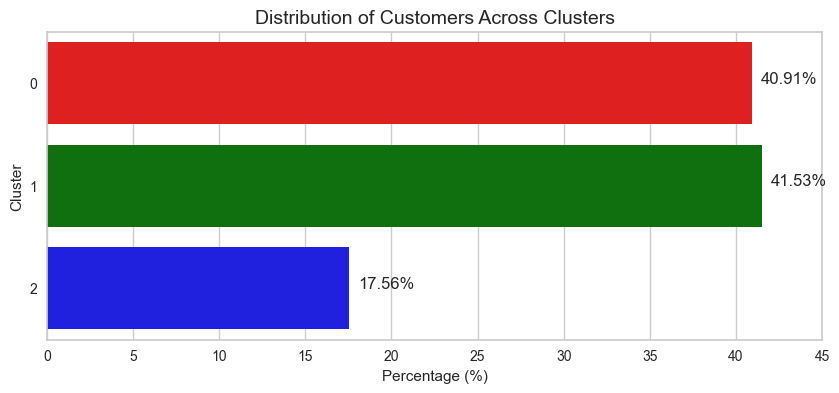

In [131]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

From the above graph, we can see that cluster 0 and cluster 1 are pretty well balanced, which tells us that our clusters arewell matched with the data points and there is less noise as well as minimal outliers

### Cluster Analysis and Customer Profiling

#### Radar Chart Approach

In [132]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

In [133]:
# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

In [134]:
# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

In [135]:
# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

In [136]:
# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

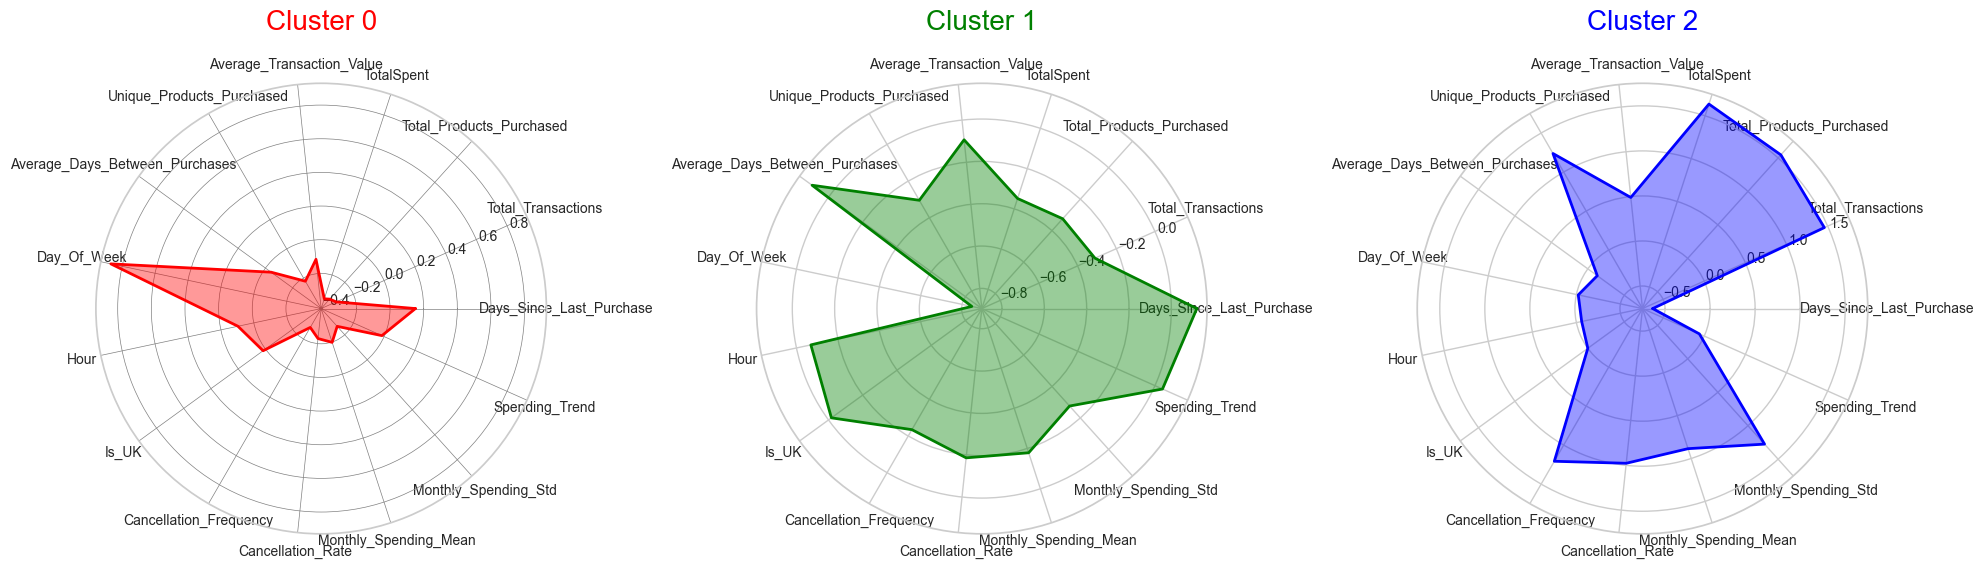

In [137]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

#### Customer Profiles from Radar Chart Analysis

**Cluster 0 (Red):
Sporadic shoppers that prefer weekend shopping:**

Customers in this cluster tend to spend less, with a lower number of transactions and products purchased.
They have a slight tendency to shop during the weekends, as indicated by the very high Day_of_Week value.
Their spending trend is relatively stable but on the lower side, and they have a low monthly spending variation (low Monthly_Spending_Std).
These customers have not engaged in many cancellations, showing a low cancellation frequency and rate.
The average transaction value is on the lower side, indicating that when they do shop, they tend to spend less per transaction.

**Cluster 1 (Green): Infrequent big spenders with a high spending trend:**

Customers in this cluster show a moderate level of spending, but their transactions are not very frequent, as indicated by the high Days_Since_Last_Purchase and Average_Days_Between_Purchases.
They have a very high spending trend, indicating that their spending has been increasing over time.
These customers prefer shopping late in the day, as indicated by the high Hour value.
They have a tendency to cancel a moderate number of transactions, with a medium cancellation frequency and rate.
Their average transaction value is relatively high, meaning that when they shop, they tend to make substantial purchases.


**Cluster 2 (Blue): Frequent high spenders with high rate of cancelations:**

Customers in this cluster are high spenders with a very high total spend, and they purchase a wide variety of unique products.
They engage in frequent transactions, but also have a high cancellation frequency and rate.
These customers have a very low average time between purchases, and they tend to shop early in the day (low Hour value).
Their monthly spending shows high variability, indicating that their spending patterns might be less predictable compared to other clusters.
Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.

To get a better breakdown of the features, we can also do a histogram to better visualize this

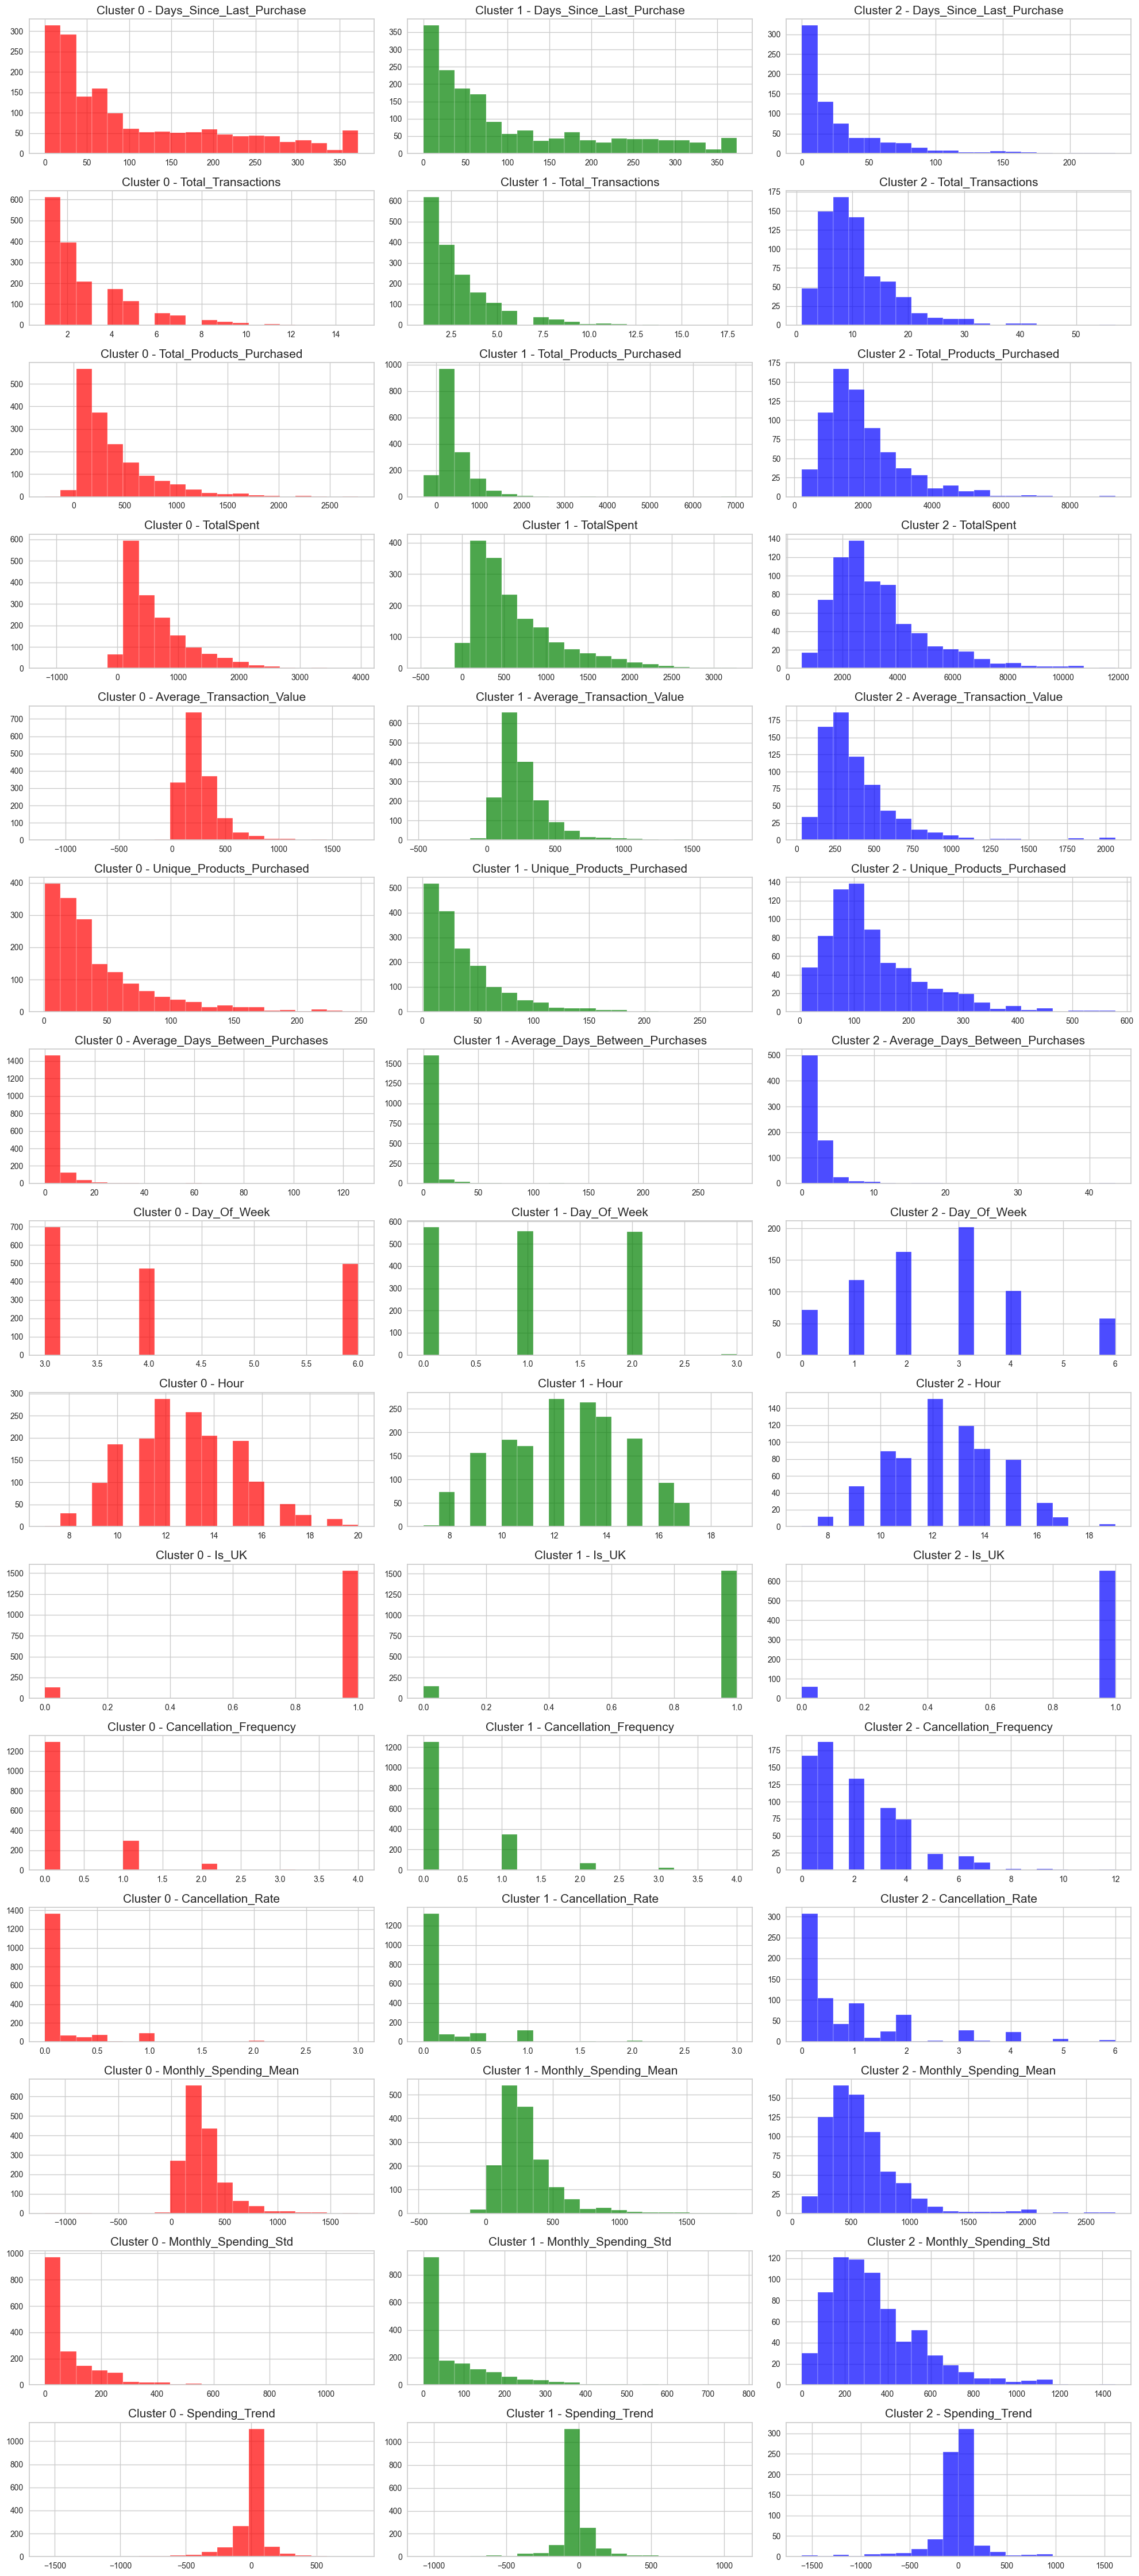

In [139]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

### Recommendation System

In the final phase of this project, we will set up a recommendation system to enhance the online shopping experience for our clusters of customers. This system will suggest products to customers based on the purchasing patterns prevalent in their respective clusters. As a reminder, during the customer data preparation stage, I isolated a small fraction (5%) of the customers identified as outliers and reserved them in a separate dataset called `outliers_data`.

Our recommender system will personalize recommendations, suggesting the top three products popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales. 

In [140]:
# Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

In [141]:
# Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

In [142]:
# Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

In [144]:
# Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

In [145]:
# Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

In [148]:
# Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

In [149]:
# Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [150]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
15740.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
15723.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
17406.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,17003,BROCADE RING PURSE,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
17361.0,84879,ASSORTED COLOUR BIRD ORNAMENT,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,17003,BROCADE RING PURSE
15304.0,84879,ASSORTED COLOUR BIRD ORNAMENT,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,17003,BROCADE RING PURSE
14314.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
15271.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
17582.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
17819.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
